# Some regularizations and optimization algorithms on [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
By [Zahra Taheri](https://github.com/zahta), November 27, 2020

### Preperation for Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip dataset files from google drive to content folder in colab

import os

if os.path.exists("/content/cifar-100-python/")==False:
    print("unzip files!")
    !unzip -q "/content/drive/My Drive/cifar-100.zip"

unzip files!


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

import pickle

## Loading CIFAR-100

In [4]:
def get_proper_images(raw):
    raw_float = np.array(raw, dtype=float) 
    images = raw_float.reshape([-1, 3, 32, 32])
    images = images.transpose([0, 2, 3, 1])
    return images.astype(int)

#def onehot_labels(labels):
#    return np.eye(100)[labels]

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train_data=get_proper_images(unpickle('cifar-100-python/train')[b'data'])
#train_labels=onehot_labels(unpickle('cifar-100-python/train')[b'fine_labels'])
train_labels=unpickle('cifar-100-python/train')[b'fine_labels']
test_data=get_proper_images(unpickle('cifar-100-python/test')[b'data'])
#test_labels=onehot_labels(unpickle('cifar-100-python/test')[b'fine_labels'])
test_labels=unpickle('cifar-100-python/test')[b'fine_labels']

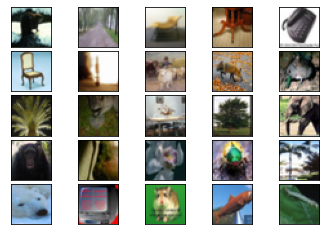

In [6]:
# display some random training images in a grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

## Preparation of the dataset

In [7]:
#some_digit = train_data[0]
#some_digit_image = some_digit
#plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
#plt.axis("off")
#plt.show()

In [8]:
#nsamples, a,b,c = train_data.shape
#print(train_data.shape)
#X_train= train_data.reshape((nsamples,a*b*c))
#nsamples2, a2,b2,c2 = test_data.shape
#X_test= test_data.reshape((nsamples2,a2*b2*c2))


#from sklearn import preprocessing

#scale = preprocessing.MinMaxScaler()
#X_train = scale.fit_transform(X_train)
#X_test = scale.fit_transform(X_test)
#print(X_train.shape)

#train_data= X_train.reshape((nsamples, a,b,c))
#test_data= X_test.reshape((nsamples2, a2,b2,c2))
#print(train_data.shape)

In [9]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [10]:
tensor_x2 = torch.Tensor(test_data) # transform to torch tensor
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2) # create your datset

In [11]:
tensor_y

tensor([19, 29,  0,  ...,  3,  7, 73])

## Building Feedforward Neural Networks with PyTorch

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 3*32*32).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100        
            
            

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 3*32*32).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [19]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [21]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [22]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [23]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [24]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [25]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 14.1746
Epoch: 001/038 Train Cost: 4.0465
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.1413
Epoch: 002/038 Train Cost: 3.8332
Time elapsed: 0.11 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.9738
Epoch: 003/038 Train Cost: 3.6763
Time elapsed: 0.16 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.6634
Epoch: 004/038 Train Cost: 3.5693
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.7430
Epoch: 005/038 Train Cost: 3.4829
Time elapsed: 0.27 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.5597
Epoch: 006/038 Train Cost: 3.4047
Time elapsed: 0.32 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.3894
Epoch: 007/038 Train Cost: 3.3594
Time elapsed: 0.38 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.3766
Epoch: 008/038 Train Cost: 3.3496
Time elapsed: 0.43 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.3913
Epoch: 009/038 Train Cost: 3.2744
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.2534
Epoch: 010/038 Train Cost:

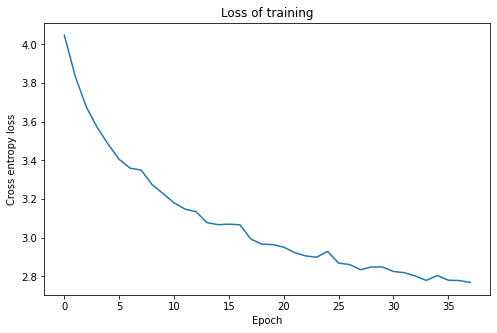

In [27]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model B: 7 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [28]:
batch_size = 128
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

76


In [29]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [30]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.dropout2 = nn.Dropout(0.25)
        # non-linearity 4
        self.relu4 = nn.ReLU()
        
        # linear function 5
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        # non-linearity 5
        self.relu5 = nn.ReLU()

        # linear function 6
        self.fc6 = nn.Linear(hidden_dim5, hidden_dim6)
        # non-linearity 6
        self.relu6 = nn.ReLU()
        
        # linear function 7
        self.fc7 = nn.Linear(hidden_dim6, hidden_dim7)
        # non-linearity 7
        self.relu7 = nn.ReLU()
        
        # linear function 8 (readout)
        self.fc8 = nn.Linear(hidden_dim7, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        out = self.dropout1(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        # linear function 4
        out = self.fc4(out)
        out = self.dropout2(out)
        # non-linearity 4
        out = self.relu4(out)
        
        # linear function 5
        out = self.fc5(out)
        # non-linearity 5
        out = self.relu5(out)

        # linear function 6
        out = self.fc6(out)
        # non-linearity 6
        out = self.relu6(out)
        
        # linear function 7
        out = self.fc7(out)
        # non-linearity 7
        out = self.relu7(out)
        
        #linear function 8 (readout)
        out = self.fc8(out)
        return out       
    

In [31]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 1024
hidden_dim4 = 512
hidden_dim5 = 200
hidden_dim6 = 200
hidden_dim7 = 200

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [32]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
           Dropout-5              [-1, 1, 1500]               0
            Linear-6              [-1, 1, 1024]       1,537,024
              ReLU-7              [-1, 1, 1024]               0
            Linear-8               [-1, 1, 512]         524,800
           Dropout-9               [-1, 1, 512]               0
             ReLU-10               [-1, 1, 512]               0
           Linear-11               [-1, 1, 200]         102,600
             ReLU-12               [-1, 1, 200]               0
           Linear-13               [-1, 1, 200]          40,200
             ReLU-14               [-1,

In [33]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.01
LAMBDA = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.9)

#### Train the model

In [34]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/076 | Batch 000/391 | Cost: 4.6445
Epoch: 001/076 Train Cost: 4.0749
Time elapsed: 0.07 min
Epoch: 002/076 | Batch 000/391 | Cost: 4.0183
Epoch: 002/076 Train Cost: 3.9491
Time elapsed: 0.14 min
Epoch: 003/076 | Batch 000/391 | Cost: 3.9197
Epoch: 003/076 Train Cost: 3.8546
Time elapsed: 0.20 min
Epoch: 004/076 | Batch 000/391 | Cost: 3.8693
Epoch: 004/076 Train Cost: 3.8028
Time elapsed: 0.27 min
Epoch: 005/076 | Batch 000/391 | Cost: 3.8342
Epoch: 005/076 Train Cost: 3.7165
Time elapsed: 0.34 min
Epoch: 006/076 | Batch 000/391 | Cost: 3.7591
Epoch: 006/076 Train Cost: 3.6347
Time elapsed: 0.40 min
Epoch: 007/076 | Batch 000/391 | Cost: 3.7256
Epoch: 007/076 Train Cost: 3.5721
Time elapsed: 0.47 min
Epoch: 008/076 | Batch 000/391 | Cost: 3.5291
Epoch: 008/076 Train Cost: 3.5494
Time elapsed: 0.54 min
Epoch: 009/076 | Batch 000/391 | Cost: 3.3573
Epoch: 009/076 Train Cost: 3.4778
Time elapsed: 0.61 min
Epoch: 010/076 | Batch 000/391 | Cost: 3.5537
Epoch: 010/076 Train Cost: 

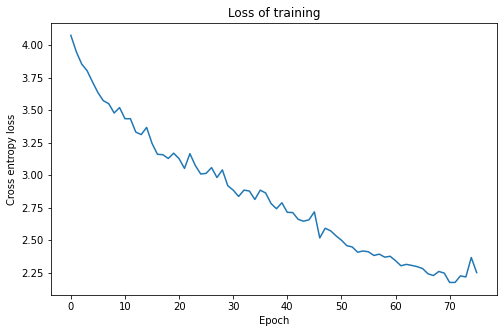

In [35]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [36]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [37]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [38]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [39]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [40]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [41]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [42]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 13.7689
Epoch: 001/038 Train Cost: 4.0378
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.2482
Epoch: 002/038 Train Cost: 3.8061
Time elapsed: 0.12 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.9102
Epoch: 003/038 Train Cost: 3.6903
Time elapsed: 0.17 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.9137
Epoch: 004/038 Train Cost: 3.5607
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.7692
Epoch: 005/038 Train Cost: 3.4847
Time elapsed: 0.28 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.4171
Epoch: 006/038 Train Cost: 3.4129
Time elapsed: 0.33 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.4775
Epoch: 007/038 Train Cost: 3.3480
Time elapsed: 0.39 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.1426
Epoch: 008/038 Train Cost: 3.3268
Time elapsed: 0.44 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.3849
Epoch: 009/038 Train Cost: 3.2754
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.4790
Epoch: 010/038 Train Cost:

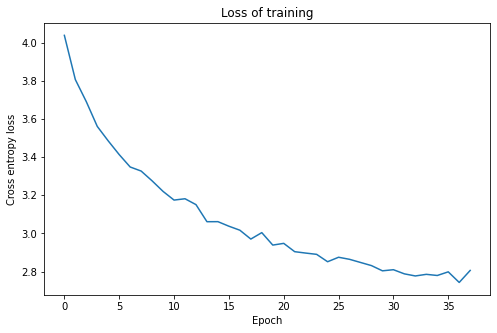

In [43]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 2. SGD Momentum

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [44]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [45]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [46]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [47]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [48]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [49]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.7)

#### Train the model

In [50]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 16.6517
Epoch: 001/038 Train Cost: 3.9562
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.0139
Epoch: 002/038 Train Cost: 3.6939
Time elapsed: 0.11 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.6749
Epoch: 003/038 Train Cost: 3.5791
Time elapsed: 0.16 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.7340
Epoch: 004/038 Train Cost: 3.4706
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.5089
Epoch: 005/038 Train Cost: 3.3743
Time elapsed: 0.27 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.4683
Epoch: 006/038 Train Cost: 3.3306
Time elapsed: 0.33 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.3415
Epoch: 007/038 Train Cost: 3.2823
Time elapsed: 0.38 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.2504
Epoch: 008/038 Train Cost: 3.2187
Time elapsed: 0.44 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.3491
Epoch: 009/038 Train Cost: 3.1923
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.2195
Epoch: 010/038 Train Cost:

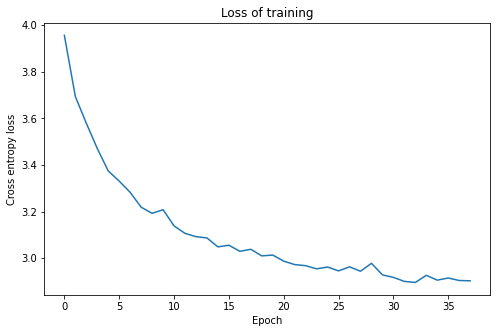

In [51]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 3. SGD Nesterov

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [52]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [54]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [55]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [56]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [57]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.7, nesterov=True)

#### Train the model

In [58]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 14.5611
Epoch: 001/038 Train Cost: 3.9451
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 3.7783
Epoch: 002/038 Train Cost: 3.7199
Time elapsed: 0.11 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.8315
Epoch: 003/038 Train Cost: 3.5830
Time elapsed: 0.16 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.7070
Epoch: 004/038 Train Cost: 3.5725
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.6637
Epoch: 005/038 Train Cost: 3.3851
Time elapsed: 0.27 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.4773
Epoch: 006/038 Train Cost: 3.2991
Time elapsed: 0.33 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.1701
Epoch: 007/038 Train Cost: 3.2767
Time elapsed: 0.38 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.4196
Epoch: 009/038 Train Cost: 3.2746
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.3842
Epoch: 010/038 Train Cost: 3.1647
Time elapsed: 0.54 min
Epoch: 011/038 | Batch 000/391 | Cost: 3.0789
Epoch: 011/038 Train Cost:

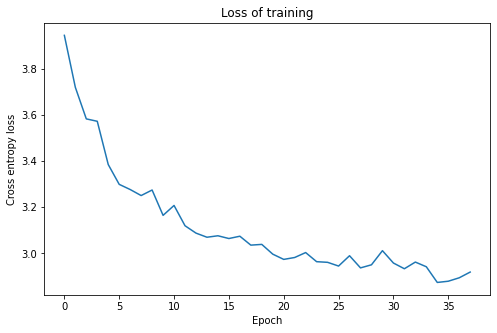

In [59]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 4. Adam

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [60]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [61]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [62]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [63]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [64]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [65]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [66]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 16.9464
Epoch: 001/038 Train Cost: 4.0610
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.1508
Epoch: 002/038 Train Cost: 3.9226
Time elapsed: 0.12 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.7570
Epoch: 003/038 Train Cost: 3.7770
Time elapsed: 0.18 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.7635
Epoch: 004/038 Train Cost: 3.9357
Time elapsed: 0.24 min
Epoch: 005/038 | Batch 000/391 | Cost: 4.0919
Epoch: 005/038 Train Cost: 3.9157
Time elapsed: 0.30 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.9263
Epoch: 006/038 Train Cost: 3.7438
Time elapsed: 0.36 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.7532
Epoch: 007/038 Train Cost: 3.7856
Time elapsed: 0.42 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.6658
Epoch: 008/038 Train Cost: 3.6877
Time elapsed: 0.48 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.6607
Epoch: 009/038 Train Cost: 3.6825
Time elapsed: 0.54 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.7043
Epoch: 010/038 Train Cost:

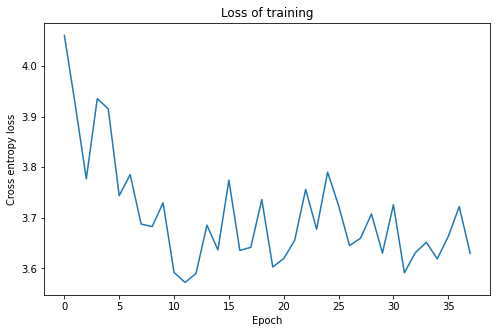

In [67]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 5. Adagrad

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [68]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [69]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [70]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [71]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [72]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [73]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [74]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 16.8851
Epoch: 001/038 Train Cost: 3.8758
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 3.9337
Epoch: 002/038 Train Cost: 3.6548
Time elapsed: 0.11 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.7643
Epoch: 003/038 Train Cost: 3.5489
Time elapsed: 0.17 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.6567
Epoch: 004/038 Train Cost: 3.4674
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.6218
Epoch: 005/038 Train Cost: 3.4116
Time elapsed: 0.28 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.3058
Epoch: 006/038 Train Cost: 3.3321
Time elapsed: 0.33 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.4308
Epoch: 007/038 Train Cost: 3.3141
Time elapsed: 0.39 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.6466
Epoch: 008/038 Train Cost: 3.2595
Time elapsed: 0.44 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.3831
Epoch: 009/038 Train Cost: 3.2456
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.1596
Epoch: 010/038 Train Cost:

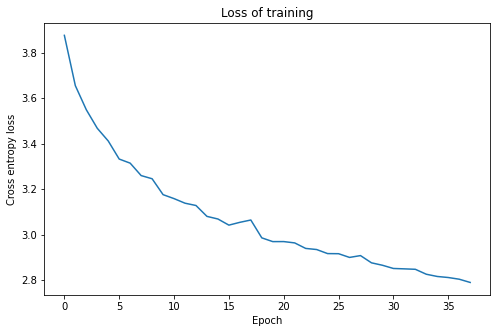

In [75]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 6. Adadelta

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [76]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [77]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [78]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [79]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [80]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [81]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [82]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 13.5763
Epoch: 001/038 Train Cost: 4.4366
Time elapsed: 0.07 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.5941
Epoch: 002/038 Train Cost: 4.2138
Time elapsed: 0.13 min
Epoch: 003/038 | Batch 000/391 | Cost: 4.3617
Epoch: 003/038 Train Cost: 4.0700
Time elapsed: 0.20 min
Epoch: 004/038 | Batch 000/391 | Cost: 4.1138
Epoch: 004/038 Train Cost: 3.9675
Time elapsed: 0.27 min
Epoch: 005/038 | Batch 000/391 | Cost: 4.1618
Epoch: 005/038 Train Cost: 3.8843
Time elapsed: 0.33 min
Epoch: 006/038 | Batch 000/391 | Cost: 4.0130
Epoch: 006/038 Train Cost: 3.8126
Time elapsed: 0.40 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.9460
Epoch: 007/038 Train Cost: 3.7538
Time elapsed: 0.46 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.8674
Epoch: 008/038 Train Cost: 3.7052
Time elapsed: 0.53 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.9243
Epoch: 009/038 Train Cost: 3.6570
Time elapsed: 0.59 min
Epoch: 010/038 | Batch 000/391 | Cost: 4.0201
Epoch: 010/038 Train Cost:

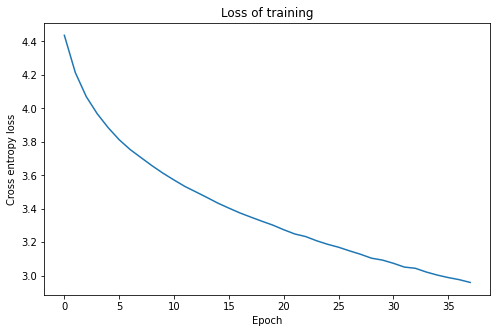

In [83]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 7. Adamax

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [84]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [85]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [86]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [87]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [88]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [89]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [90]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 14.7671
Epoch: 001/038 Train Cost: 3.9878
Time elapsed: 0.07 min
Epoch: 002/038 | Batch 000/391 | Cost: 3.9649
Epoch: 002/038 Train Cost: 3.7693
Time elapsed: 0.13 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.7591
Epoch: 003/038 Train Cost: 3.6697
Time elapsed: 0.19 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.6502
Epoch: 004/038 Train Cost: 3.6175
Time elapsed: 0.25 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.4472
Epoch: 005/038 Train Cost: 3.4960
Time elapsed: 0.32 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.4866
Epoch: 006/038 Train Cost: 3.4415
Time elapsed: 0.38 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.2969
Epoch: 007/038 Train Cost: 3.4896
Time elapsed: 0.44 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.5404
Epoch: 008/038 Train Cost: 3.4174
Time elapsed: 0.50 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.4541
Epoch: 009/038 Train Cost: 3.3813
Time elapsed: 0.57 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.2052
Epoch: 010/038 Train Cost:

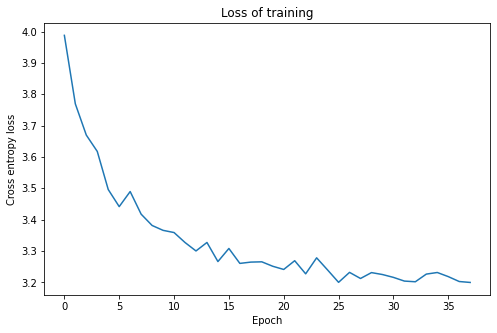

In [91]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 8. RMSProp

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [106]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [107]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [124]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [125]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [126]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
           Dropout-4              [-1, 1, 1500]               0
              ReLU-5              [-1, 1, 1500]               0
            Linear-6               [-1, 1, 512]         768,512
              ReLU-7               [-1, 1, 512]               0
            Linear-8               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 32.79
Estimated Total Size (MB): 32.87
----------------------------------------------------------------


In [127]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [128]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 20.3039
Epoch: 001/038 Train Cost: 4.8628
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 4.9749
Epoch: 002/038 Train Cost: 4.5238
Time elapsed: 0.11 min
Epoch: 003/038 | Batch 000/391 | Cost: 4.5236
Epoch: 003/038 Train Cost: 4.5463
Time elapsed: 0.17 min
Epoch: 004/038 | Batch 000/391 | Cost: 4.5736
Epoch: 004/038 Train Cost: 4.5774
Time elapsed: 0.22 min
Epoch: 005/038 | Batch 000/391 | Cost: 4.5674
Epoch: 005/038 Train Cost: 4.6149
Time elapsed: 0.28 min
Epoch: 006/038 | Batch 000/391 | Cost: 4.6028
Epoch: 006/038 Train Cost: 37.1871
Time elapsed: 0.33 min
Epoch: 007/038 | Batch 000/391 | Cost: 36.9046
Epoch: 007/038 Train Cost: 4.6170
Time elapsed: 0.39 min
Epoch: 008/038 | Batch 000/391 | Cost: 4.6065
Epoch: 008/038 Train Cost: 4.6170
Time elapsed: 0.44 min
Epoch: 009/038 | Batch 000/391 | Cost: 4.6052
Epoch: 009/038 Train Cost: 4.6170
Time elapsed: 0.49 min
Epoch: 010/038 | Batch 000/391 | Cost: 4.6067
Epoch: 010/038 Train Cos

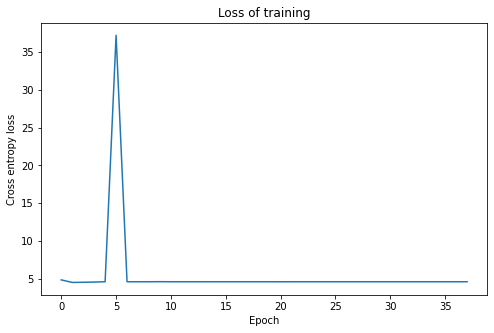

In [129]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Batch normalization

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [155]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [156]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [157]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        #out = self.BatchNorm1d1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.BatchNorm1d2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [158]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [159]:
#summary(model, (1,3*32*32))

In [160]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [161]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/038 | Batch 000/391 | Cost: 4.7132
Epoch: 001/038 Train Cost: 3.8215
Time elapsed: 0.06 min
Epoch: 002/038 | Batch 000/391 | Cost: 3.7977
Epoch: 002/038 Train Cost: 3.6491
Time elapsed: 0.12 min
Epoch: 003/038 | Batch 000/391 | Cost: 3.6444
Epoch: 003/038 Train Cost: 3.5827
Time elapsed: 0.18 min
Epoch: 004/038 | Batch 000/391 | Cost: 3.5176
Epoch: 004/038 Train Cost: 3.5511
Time elapsed: 0.23 min
Epoch: 005/038 | Batch 000/391 | Cost: 3.4911
Epoch: 005/038 Train Cost: 3.4233
Time elapsed: 0.29 min
Epoch: 006/038 | Batch 000/391 | Cost: 3.5826
Epoch: 006/038 Train Cost: 3.4298
Time elapsed: 0.35 min
Epoch: 007/038 | Batch 000/391 | Cost: 3.4737
Epoch: 007/038 Train Cost: 3.3630
Time elapsed: 0.41 min
Epoch: 008/038 | Batch 000/391 | Cost: 3.5014
Epoch: 008/038 Train Cost: 3.3208
Time elapsed: 0.46 min
Epoch: 009/038 | Batch 000/391 | Cost: 3.3330
Epoch: 009/038 Train Cost: 3.2306
Time elapsed: 0.52 min
Epoch: 010/038 | Batch 000/391 | Cost: 3.1237
Epoch: 010/038 Train Cost: 

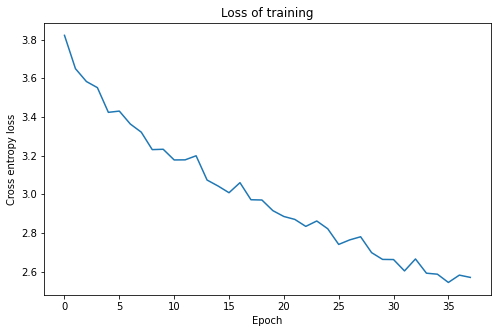

In [162]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Results of regularizations

| Model Name                    | Training Accuracy | Test Accuracy | Training Accuracy(Dropout) | Test Accuracy(Dropout) | 
|--------------------------------|----------|----------|----------|----------|
| Model A |  36.18  |  26.17  |  32.77   |  25.46  |
| Model B |  57.33  |  21.97  |  41.59   |  23.65   |

## Results of optimizations (Test accuracy)
- With dropouts from the regularization part
- Best optimizer for each model is bolded

| Optimizer                    | Model A | 
|--------------------------------|----------|
| SGD |  24.73  | 
| SGD Momentum |  24.99  |
| SGD Nesterov |  24.84  |
| Adam |  13.55  | 
| **Adagrad** |  **26.32**  |
| Adadelta |  21.43  |
| Adamax |  20.89  |
| RMSProp |  1.00  |


### Batch normalization
- With dropouts from the regularization part
- We employed the best optimizer for the model from the previous table

| Model Name | Optimizer| Training Accuracy | Test Accuracy |
|------------|----------|----------|----------|
| Model A |  Adagrad  |  45.19  |  27.56  |
